<a href="https://colab.research.google.com/github/the-SQuAD-squad/IR/blob/tfidf/IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install wikipedia-api

  Created wheel for wikipedia-api: filename=Wikipedia_API-0.5.4-cp37-none-any.whl size=13462 sha256=603d5b408624fab7983389707df073833991322430b08d6e9d74e11b151e9f37
  Stored in directory: /root/.cache/pip/wheels/bf/40/42/ba1d497f3712281b659dd65b566fc868035c859239571a725a
Successfully built wikipedia-api


In [2]:
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('en')
cat = wiki_wiki.page("Category:Physics")
print("Category members: Category:Physics")
for p in cat.categorymembers.values():
  if p.namespace == wikipediaapi.Namespace.CATEGORY:
    # it is category, so you have to make decision
    # if you want to fetch also text from pages that belong
    # to this category
    print(p)
  elif p.namespace == wikipediaapi.Namespace.MAIN:
    # it is page => we can get text
    print(p)
    print(p.text)

Category members: Category:Physics
Physics (id: ??, ns: 0)
Physics (from Ancient Greek: φυσική (ἐπιστήμη), romanized: physikḗ (epistḗmē), lit. 'knowledge of nature', from φύσις phýsis 'nature') is the natural science that studies matter, its motion and behavior through space and time, and the related entities of energy and force. Physics is one of the most fundamental scientific disciplines, and its main goal is to understand how the universe behaves.Physics is one of the oldest academic disciplines and, through its inclusion of astronomy, perhaps the oldest. Over much of the past two millennia, physics, chemistry, biology, and certain branches of mathematics were a part of natural philosophy, but during the Scientific Revolution in the 17th century these natural sciences emerged as unique research endeavors in their own right. Physics intersects with many interdisciplinary areas of research, such as biophysics and quantum chemistry, and the boundaries of physics are not rigidly define

In [67]:
def print_categorymembers(categorymembers, level=0, max_level=2):
        for c in categorymembers.values():
            print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
            if c.ns == wikipediaapi.Namespace.CATEGORY and level < max_level:
                print_categorymembers(c.categorymembers, level=level + 1, max_level=max_level)

cat = wiki_wiki.page("Category:Tom Cruise")
print_categorymembers(cat.categorymembers)

****: Tom Cruise (ns: 0)
****: List of awards and nominations received by Tom Cruise (ns: 0)
****: Being Tom Cruise (ns: 0)
****: Cruise/Wagner Productions (ns: 0)
****: Tom Cruise filmography (ns: 0)
****: Ethan Hunt (ns: 0)
****: ScienTOMogy (ns: 0)
****: Tom Cruise: All the World's a Stage (ns: 0)
****: Tom Cruise: An Unauthorized Biography (ns: 0)
****: Tom Cruise: Unauthorized (ns: 0)
****: Category:Cruise/Wagner Productions films (ns: 14)
*****: Cruise/Wagner Productions (ns: 0)
*****: Ask the Dust (film) (ns: 0)
*****: Death Race (film) (ns: 0)
*****: Death Race (franchise) (ns: 0)
*****: Elizabethtown (film) (ns: 0)
*****: The Eye (2008 film) (ns: 0)
*****: The Last Samurai (ns: 0)
*****: Mission: Impossible – Ghost Protocol (ns: 0)
*****: Mission: Impossible – Rogue Nation (ns: 0)
*****: Mission: Impossible (film series) (ns: 0)
*****: Mission: Impossible (film) (ns: 0)
*****: Mission: Impossible 2 (ns: 0)
*****: Narc (film) (ns: 0)
*****: The Others (2001 film) (ns: 0)
*****:

In [ ]:
wiki_wiki = wikipediaapi.Wikipedia('en')

page_py = wiki_wiki.page('Python_(programming_language)')
print(page_py.text)

In [45]:
def get_categorymembers(categorymembers, members, level=0, max_level=2):
    for c in categorymembers.values():
        #print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
        #print(c.title)
        members.append(c.title)
        if c.ns == wikipediaapi.Namespace.CATEGORY and level < max_level:
            get_categorymembers(c.categorymembers, members, level=level + 1, max_level=max_level)

members = []
cat = wiki_wiki.page("Category:Tom Cruise")
print("Category members: Category:Tom Cruise")
get_categorymembers(cat.categorymembers, members)
print(members)

# wiki_wiki = wikipediaapi.Wikipedia('en')
# page_py = wiki_wiki.page('Python_(programming_language)')
# print(page_py.text)
# page_py = wiki_wiki.page('File:Valkyrie poster.jpg')
# print("Page - Exists: %s" % page_py.exists())
# print("Page - Summary: %s" % page_py.summary[0:60])

Category members: Category:Tom Cruise
['Tom Cruise', 'List of awards and nominations received by Tom Cruise', 'Being Tom Cruise', 'Cruise/Wagner Productions', 'Tom Cruise filmography', 'Ethan Hunt', 'ScienTOMogy', "Tom Cruise: All the World's a Stage", 'Tom Cruise: An Unauthorized Biography', 'Tom Cruise: Unauthorized', 'Category:Cruise/Wagner Productions films', 'Cruise/Wagner Productions', 'Ask the Dust (film)', 'Death Race (film)', 'Death Race (franchise)', 'Elizabethtown (film)', 'The Eye (2008 film)', 'The Last Samurai', 'Mission: Impossible – Ghost Protocol', 'Mission: Impossible – Rogue Nation', 'Mission: Impossible (film series)', 'Mission: Impossible (film)', 'Mission: Impossible 2', 'Narc (film)', 'The Others (2001 film)', 'Shattered Glass (film)', 'Suspect Zero', 'Vanilla Sky', 'War of the Worlds (2005 film)', 'Without Limits', 'Category:Cultural depictions of Tom Cruise', '2DTV', '200 (South Park)', '201 (South Park)', 'Cartoon Wars Part II', 'Headcases', 'Scary Movie 4', '

In [57]:
from tqdm.notebook import tqdm
pages = [member for member in members if not (member.startswith("Category:") or member.startswith("File:"))]

# remove Tom Cruise:Unauthorized
del pages[9]
print(pages)

['Tom Cruise', 'List of awards and nominations received by Tom Cruise', 'Being Tom Cruise', 'Cruise/Wagner Productions', 'Tom Cruise filmography', 'Ethan Hunt', 'ScienTOMogy', "Tom Cruise: All the World's a Stage", 'Tom Cruise: An Unauthorized Biography', 'Tom Cruise: Unauthorized', 'Cruise/Wagner Productions', 'Ask the Dust (film)', 'Death Race (film)', 'Death Race (franchise)', 'Elizabethtown (film)', 'The Eye (2008 film)', 'The Last Samurai', 'Mission: Impossible – Ghost Protocol', 'Mission: Impossible – Rogue Nation', 'Mission: Impossible (film series)', 'Mission: Impossible (film)', 'Mission: Impossible 2', 'Narc (film)', 'The Others (2001 film)', 'Shattered Glass (film)', 'Suspect Zero', 'Vanilla Sky', 'War of the Worlds (2005 film)', 'Without Limits', '2DTV', '200 (South Park)', '201 (South Park)', 'Cartoon Wars Part II', 'Headcases', 'Scary Movie 4', 'Superhero Movie', 'Trapped in the Closet (South Park)', 'Ask the Dust (film)', 'Elizabethtown (film)', 'Jack Reacher (film)', 'J

In [58]:
wiki_wiki = wikipediaapi.Wikipedia('en')
pages_text = {}
for page in tqdm(pages):
    page_py = wiki_wiki.page(page)
    pages_text[page] = page_py.text

pages_text

{'200 (South Park)': '"200" is the fifth episode of the fourteenth season of the American animated television series South Park, and the 200th overall episode of the series. It originally aired on Comedy Central in the United States on April 14, 2010. In the episode, Tom Cruise and all other celebrities who have been mocked by residents of South Park in the past plan to file a class action lawsuit against the town, but Cruise promises to end the lawsuit if the town can get the Islamic prophet Muhammad to meet him.\nThe episode was written and directed by series co-creator Trey Parker. To celebrate their landmark episode, Parker and fellow series co-creator Matt Stone combined many of South Park\'s past storylines and controversies. The Muhammad subplot, similar to the one previously featured in the season 10 episode "Cartoon Wars", refers to Comedy Central\'s past refusal to allow images of Muhammad to be shown on the network in response to the riots and threats generated from controve

In [68]:
len(pages_text)

41

In [ ]:
for title in pages_text:
    stop_index = pages_text[title].rfind("References")
    pages_text[title] = pages_text[title][:stop_index]

In [81]:
#@title Init { form-width: "25%" }
import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import re
import string
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

!pip install tokenizers
from tokenizers import BertWordPieceTokenizer

from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# BERT params
max_seq_length = 512
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)


     |████████████████████████████████| 3.2MB 6.8MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [169]:
#@title df creation { form-width: "25%" }

# the official dataset is identical to the provided one
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O training_set.json

with open("training_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_original = pd.DataFrame(rows)

--2021-02-27 18:04:15--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘training_set.json’

training_set.json   100%[===================>]  28.88M   105MB/s    in 0.3s    

2021-02-27 18:04:16 (105 MB/s) - ‘training_set.json’ saved [30288272/30288272]



In [170]:
#@title preprocessing { form-width: "25%" }

import nltk
import re 
import math
import random as rand

nltk.download('punkt')
from nltk.stem.porter import PorterStemmer # for stemming

from tqdm.notebook import tqdm


def preprocess_text(text):
    """
    Given an iterable containing sentences, pre-process each sentence.

    :param: 
        - text: list of text to be pre-processed (Iterable)
    :return:
        - text: pre-processed text (List)
    """

    REPLACE_WITH_SPACE = re.compile(r"\n") 
    text = [REPLACE_WITH_SPACE.sub(" ", line) for line in text]

    # we don't remove symbols, but just put a space before and after them. We did this because we noticed that Glove contains an embedding also for
    # them, so, in this way, we are able to split these symbols from the text when computing sentence tokens
    text = [re.sub(r"([(.;:!\'ˈ~?,\"(\[\])\\\/\-–\t```<>_#$€@%*+—°′″“”×’^₤₹‘])", r'', line) for line in text]

    # we noticed that in the text sometimes we find numbers and the following word merged together (ex: 1980february),
    # so we put a space between the number and the word
    text = [re.sub(r"(\d+)([a-z]+)", r'\1 \2', line) for line in text] 
    text = [re.sub('\s{2,}', ' ', line.strip()) for line in text]   # replacing more than one consecutive blank spaces with only one of them

    return text

    stemmed_lines = []
    for line in tqdm(text):
        tokens = nltk.word_tokenize(line)
        stems = []
        for item in tokens:
            stems.append(PorterStemmer().stem(item))
        stemmed_lines.append(' '.join(stems))

    return stemmed_lines

# Creating a copy of the original dataframe (we do this because we want to be able to compare the results of our processing with the original data)
df = df_original.copy()

# pre-process passage and question text
df['passage'] = preprocess_text(df_original['passage'])
df['question'] = preprocess_text(df_original['question'])
df['answer_text'] = preprocess_text(df_original['answer_text'])


# Comparing Original and Pre-Processed
for i in range(3):
    a = rand.randint(0,1000)
    print('ORIGINAL AND PREPROCESSED PASSAGE:')
    print(df_original.iloc[a]['passage'])
    print(df.iloc[a]['passage'])
    
    print()
    print('ORIGINAL AND PREPROCESSED QUESTION:')
    print(df_original.iloc[a]['question'])
    print(df.iloc[a]['question'])
    print()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
ORIGINAL AND PREPROCESSED PASSAGE:
In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for; the letter was addressed to Angela Merkel and Nkosazana Dlamini-Zuma, urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively, which will start to set the priorities in development funding before a main UN summit in September 2015 that will establish new development goals for the generation.
In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for the letter was addressed to Angela Merkel and Nkosazana DlaminiZuma urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively which will start to set the priorities in development funding before a main UN summit in September 2015 that will establis

In [177]:
# PREPROCESS TOM CRUISE
pages_text_preprocessed = preprocess_text(pages_text.values())
titles = list(pages_text.keys())
print(len(pages_text_preprocessed))
print(len(titles))

41
41


In [171]:
df["passage"]=df["passage"].str.lower()
df["question"]=df["question"].str.lower()
df["answer_text"]=df["answer_text"].str.lower()

In [172]:
#@title clean dataset { form-width: "25%" }

!gcloud config set project feisty-mechanic-221914
!gsutil cp gs://squad_squad/error_IDs.txt ./error_IDs.txt

with open("error_IDs.txt", "r") as f:
    unwanted_id = f.read()

unwanted_id = unwanted_id.split("\n")[:-1]
df_clean = df.set_index('id')
df_clean = df_clean.drop(unwanted_id)

df_original_clean = df_original.set_index('id')
df_original_clean = df_original_clean.drop(unwanted_id)

Updated property [core/project].
Copying gs://squad_squad/error_IDs.txt...
/ [1 files][  5.7 KiB/  5.7 KiB]                                                
Operation completed over 1 objects/5.7 KiB.                                      


In [173]:
#@title split { form-width: "25%" }

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

split_value = 0.1 #@param {type:"number"} 
val_dim = int(len(df_clean['title'].unique()) * split_value)
test_titles = np.random.choice(df_clean['title'].unique(), size=val_dim, replace=False)

# creating train and val sets
df_test = df_clean[df_clean['title'].isin(test_titles)]
df_train = df_clean[~(df_clean['title'].isin(test_titles))]

df_original_test = df_original_clean[df_original_clean['title'].isin(test_titles)]
df_original_train = df_original_clean[~(df_original_clean['title'].isin(test_titles))]

In [174]:
passage_prep_train = df_train['passage'].unique().tolist()
passage_train = df_original_train['passage'].unique().tolist()

In [175]:
vectorizer =  TfidfVectorizer()
# tokenization and creation of Bag of Words representation
passage_tf_idf = vectorizer.fit_transform(passage_prep_train)

# we keep track of the original passage index before performing unique()

passage_prep_test = df_test['passage'].unique().tolist() # preprocessed
passage_test = df_original_test['passage'].unique()      # original

passage_test_tf_idf = vectorizer.transform(passage_prep_test)
question_tf_idf = vectorizer.transform(df_test['question'].tolist())

results = cosine_similarity(passage_test_tf_idf, question_tf_idf)


[0.5450475657526581, 0.6624230554001119, 0.7250979294907667]


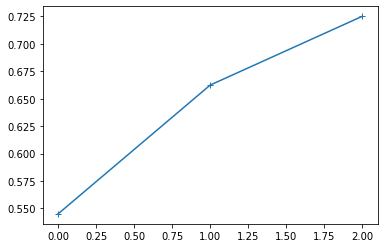

In [176]:
# single passage scores
k_results = 3

tp = 0 #true positives
accuracy = []
for k in tqdm(range(1, k_results+1)):
    for j,result in enumerate(results.T):
        result = np.argsort(result)
        if df_original_test['passage'].tolist()[j] in [text for text in passage_test[result[-k:].tolist()]]:
            tp+=1
    accuracy.append(tp/len(df_original_test))
    tp = 0

print(accuracy,sep='\n')
plt.plot(accuracy,"-+");


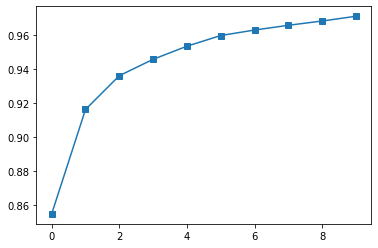

In [178]:
# full document scores
passage_group = df_original_test.groupby('passage').groups

k_results = 15
tp = 0
document_accuracy = []
for k in tqdm(range(1,11)):
    for j,result in enumerate(results.T):
        result = np.argsort(result)
        for h in range(1,k+1):
            if df_original_test.loc[passage_group[df_original_test['passage'].tolist()[j]][0]]['title'] == df_original_test.loc[passage_group[passage_test[result[-h]]][0]]['title']:
                tp+=1
                break
    document_accuracy.append(tp/len(df_original_test))
    tp = 0

plt.plot(document_accuracy,"-s")

In [209]:
# TOM CRUISE RETRIEVAL
questions = ["When was Tom Cruise born?", "What is the first Tom Cruise film?", "With whom is Brenda engaged?","What does Tom Cruise believe in?", "What is Tom Cruise character's name in Mission Impossible?", "What is Vanilla Sky?", "Who is the director of Mission Impossible?"]
passages_vectorized = vectorizer.transform(pages_text_preprocessed)
questions_vectorized = vectorizer.transform(questions)

results = cosine_similarity(questions_vectorized,passages_vectorized)


for i,row in enumerate(results):
    index = np.argmax(row)
    print(questions[i], end = " ---> ")
    print(titles[index])

When was Tom Cruise born? ---> Tom Cruise
What is the first Tom Cruise film? ---> Tom Cruise
With whom is Brenda engaged? ---> Scary Movie 4
What does Tom Cruise believe in? ---> Tom Cruise
What is Tom Cruise character's name in Mission Impossible? ---> Tom Cruise
What is Vanilla Sky? ---> Vanilla Sky
Who is the director of Mission Impossible? ---> Mission: Impossible III


In [ ]:
pages_text_preprocessed[30]

In [206]:
titles

['Tom Cruise',
 'List of awards and nominations received by Tom Cruise',
 'Being Tom Cruise',
 'Cruise/Wagner Productions',
 'Tom Cruise filmography',
 'Ethan Hunt',
 'ScienTOMogy',
 "Tom Cruise: All the World's a Stage",
 'Tom Cruise: An Unauthorized Biography',
 'Ask the Dust (film)',
 'Death Race (film)',
 'Death Race (franchise)',
 'Elizabethtown (film)',
 'The Eye (2008 film)',
 'The Last Samurai',
 'Mission: Impossible – Ghost Protocol',
 'Mission: Impossible – Rogue Nation',
 'Mission: Impossible (film series)',
 'Mission: Impossible (film)',
 'Mission: Impossible 2',
 'Narc (film)',
 'The Others (2001 film)',
 'Shattered Glass (film)',
 'Suspect Zero',
 'Vanilla Sky',
 'War of the Worlds (2005 film)',
 'Without Limits',
 '2DTV',
 '200 (South Park)',
 '201 (South Park)',
 'Cartoon Wars Part II',
 'Headcases',
 'Scary Movie 4',
 'Superhero Movie',
 'Trapped in the Closet (South Park)',
 'Jack Reacher (film)',
 'Jack Reacher: Never Go Back',
 'Mission: Impossible 7',
 'Mission: Im

# BERT QA



In [ ]:
#@title Init { form-width: "25%" }
import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import re
import string
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

!pip install tokenizers
from tokenizers import BertWordPieceTokenizer

!pip install transformers
import transformers
from transformers import AutoTokenizer
pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# BERT params
max_seq_length = 512
# Huggingface bert and associated tokenizer
#pretrained_model_str = "google/electra-small-discriminator"#
#bert_hf_layer = transformers.TFElectraModel.from_pretrained(
#    pretrained_model_str, output_attentions=True)

pretrained_model_str = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_str)

bert_hf_layer = transformers.TFRobertaModel.from_pretrained(
    pretrained_model_str, output_attentions=True)


In [ ]:
# IR-QA
# che vogliamo fa?

# se vogliamo che il sistema IRQA funzioni con domande a caso, tipo Tom Cruise
# allora dobbiamo preprocessare con il BERT tokenizer tutti i passage che ci da fuori TF-IDF.
# perchè servono le attention mask e via.

# però per valutare il sistema IRQA sulla risposta corretta come facciamo per QA
# dobbiamo confrontare con la risposta corretta nel dataset preprocessato da bert.
# Ovviamente questo si può fare solo per validation set (validation di bert che si chiama test qui su IR) e
# anche per dev set con lo script di evaluate, anche se è più un macello, forse.

# Io direi di portare qui il dataset bert_preprocessed
# e ritrovare il passage che ci da fuori IR in questo dataset.
# In questo modo abbiamo la riga, quindi i token giusti della risposta.



In [ ]:

question_tf_idf = vectorizer.transform(df_test['question'].tolist())

results = cosine_similarity(passage_test_tf_idf, question_tf_idf)

passage_test[np.argsort(result)[:5]]



array(["Spectre (2015) is the twenty-fourth James Bond film produced by Eon Productions. It features Daniel Craig in his fourth performance as James Bond, and Christoph Waltz as Ernst Stavro Blofeld, with the film marking the character's re-introduction into the series. It was directed by Sam Mendes as his second James Bond film following Skyfall, and was written by John Logan, Neal Purvis, Robert Wade and Jez Butterworth. It is distributed by Metro-Goldwyn-Mayer and Columbia Pictures. With a budget around $245 million, it is the most expensive Bond film and one of the most expensive films ever made.",
       "The story sees Bond pitted against the global criminal organisation Spectre, marking the group's first appearance in an Eon Productions film since 1971's Diamonds Are Forever,[N 2] and tying Craig's series of films together with an overarching storyline. Several recurring James Bond characters, including M, Q and Eve Moneypenny return, with the new additions of Léa Seydoux as Dr.

In [ ]:
# load bert pretrained model